# ***GRAPH DES DONNEES DE COMPTAGES***
> visu de données de trafic

In [12]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(r'C:\Users\martin.schoreisz\git\otv\otv\Transfert_Donnees')
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import pandas as pd
import geopandas as gp
import numpy as np
from shapely import wkt
import altair as alt
import folium,branca, json
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import csv, re, os, statistics, filecmp, unidecode
from math import sqrt, pi, exp
import Connexion_Transfert as ct
import Import_trafics as it
import Donnees_horaires as dh
import Outils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Exemple de Graph sur une df horaire de la DIRA**
> la structure attributaire est la même que celle de la Bdd

> ## **Visu de la répartition des données**

In [3]:
#donnees
dira=it.Comptage_Dira(r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRA\0_tmja_dira_par_section_20200106.ods',
                      r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRA\0_Annee_Complete_2019',
                     '2019')
df_horaire=dira.miseEnFormeFeuille(pd.read_excel(os.path.join(dira.dossierAnneeComplete,'Ruffec_Trimestre_1_2019.xls'),sheet_name=None),
                                 'S_MBC16.G_1','gti_otv_pg11', 'na_2010_2019_p')

In [14]:
#stats
ecartType,moyenne,median,plageMin,plageMax=dh.statsHoraires(df_horaire,'h10_11')

In [78]:
def graphTrafHoraire(df_horaire, stats, attributHeure):
    ecartType,moyenne,median,plageMin,plageMax=stats
    chartTraf=alt.Chart(df_horaire.loc[(df_horaire['type_veh']=='VL')&(~df_horaire[attributHeure].isna())][['jour',attributHeure]].
                        sort_values(attributHeure),title=attributHeure).mark_point().encode(
                x='jour',
                y=alt.Y(attributHeure+':Q',axis=alt.Axis(title='Nb de vehicule')),
                tooltip='jour').interactive()

    chartStat=alt.Chart(pd.concat([df_horaire[['jour']].assign(val=v, typeVal=t) 
                                   for v,t in ((moyenne,'moyenne'),(median,'median'))])).mark_line().encode(
        x='jour',y='val',color='typeVal')

    intervalleConf=alt.Chart(df_horaire[['jour']].assign(plageMini=plageMin, plageMaxi=plageMax)).mark_area(opacity=0.3, color='yellow').encode(
            x='jour', 
            y=alt.Y('plageMini',axis=alt.Axis(title='Nb de vehicule')),
            y2='plageMaxi')

    return intervalleConf+chartTraf+chartStat

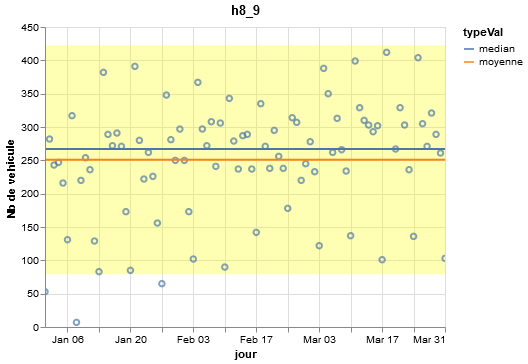

In [82]:
graphTrafHoraire(df_horaire,statsHoraires(df_horaire,'h8_9'),'h8_9')

In [81]:
alt.VConcatChart(vconcat=[alt.HConcatChart(hconcat=([graphTrafHoraire(df_horaire,statsHoraires(df_horaire,attributHeure),attributHeure) 
                           for attributHeure in [f'h{i+j}_{i+j+1}' for i in range(4)]])) for j in range(0,21,4)])

> ## **Visu de la répartition horaires des données en MJA et MJO**

In [7]:
with ct.ConnexionBdd('gti_otv_pg11') as c:
    rqt="select * from comptage.na_2010_2019_horaire where id_comptag IN (SELECT id_comptag FROM comptage.na_2010_2019_p WHERE gestionnai='DIRA' and id_comptag is not null)"
    df=pd.read_sql(rqt,c.sqlAlchemyConn)

In [9]:
dh.GraphJourneeType(df,'33-A630-10+547').save(r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\OTV\test_visu\33-A630-10+547\horaire.html')

# **Exemple de Graph sur une df horaire de la DIRCO**
> pour comparer 2 sens de circu

In [10]:
fichierMja=r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRCO\TMJA DIRCO-NA 2019_unfused.csv'
fichierMjM=r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRCO\TMJM DIRCO-NA 2019.ods'
dossierHoraire=r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRCO\données dirco'
dirco=it.Comptage_Dirco(fichierMja,fichierMjM,dossierHoraire,'2019')

dfFichierTmja=dirco.miseEnFormeFichierTmjaPourHoraire()
dfSc=dirco.miseEnFormeHoraire(dirco.tousFichierHoraires(dfFichierTmja))
dfScParSens,dicoCptok,dicoCptAssym=dirco.horaireParSens(dfSc)

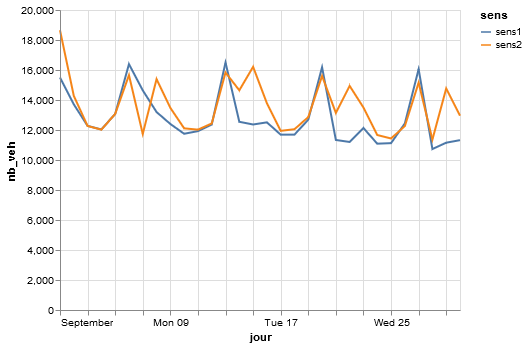

In [11]:
dh.graph2SensParJour(dicoCptok['19-A20-229+500'])

# **Exemple de Graph d'évolution a partir des donnees de l'affaire sncf-reseau**
> cf Q:\DAIT\TI\RFF-Sncf_reseau\2020 por plus de details

In [3]:
rqt="""WITH 
jointure AS (
SELECT s.*, t.id_comptag
 FROM sncf_pn_a_completer s LEFT JOIN lineaire.traf2019_bdt33_ed19_l t ON (s.id_otv_proche=t.id_ign)),
id_comptag_sncf_reseau as(
SELECT id_pt_otv2019 id_comptag
 FROM jointure
 WHERE id_pt_otv2019  IS NOT null
UNION 
SELECT id_comptag
 FROM jointure
 WHERE id_comptag IS NOT NULL),
otv_ligne AS (
SELECT id_comptag,unnest(array[2019, 2018, 2017,2016,2015,2014,2013,2012,2011,2010]) AS annee,
       unnest(array[tmja_2019, tmja_2018, tmja_2017,tmja_2016,tmja_2015, tmja_2014,tmja_2013,tmja_2012,tmja_2011,tmja_2010]) AS tmja,
       unnest(array[pc_pl_2019, pc_pl_2018, pc_pl_2017,pc_pl_2016,pc_pl_2015, pc_pl_2014,pc_pl_2013,pc_pl_2012,pc_pl_2011,pc_pl_2010]) AS pc_pl
 FROM comptage.na_2010_2019_p
 WHERE id_comptag IN (SELECT id_comptag FROM id_comptag_sncf_reseau )),
trafic_non_null AS (
 SELECT * 
  FROM otv_ligne
  WHERE tmja IS NOT NULL
  ORDER BY id_comptag, annee DESC), 
val_tmja AS (
 SELECT id_comptag,
    tmja,
    lead(tmja) OVER w AS tmja_prec,
    first_value(tmja) OVER w AS tmja_recent,
    last_value(tmja) OVER w AS tmja_ancien,
    annee,
    max(annee) OVER (PARTITION BY id_comptag) - min(annee) OVER (PARTITION BY id_comptag) AS nb_annees_tot,
    annee - lead(annee) OVER w::integer AS nb_annees_prec
   FROM trafic_non_null
  WINDOW w AS (PARTITION BY id_comptag ORDER BY annee DESC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
  ORDER BY id_comptag, annee DESC, tmja DESC), 
evolutions AS (
 SELECT id_comptag,
    tmja,
    tmja_prec,
    tmja_recent,
    tmja_ancien,
    annee,
    nb_annees_tot,
    nb_annees_prec,
        CASE
            WHEN nb_annees_prec > 0 THEN comptage.evol_annuelle_traf(tmja, tmja_prec, nb_annees_prec)
            ELSE NULL::numeric
        END AS evol_anuelle,
        CASE
            WHEN nb_annees_tot > 0 THEN comptage.evol_annuelle_traf(tmja_recent, tmja_ancien, nb_annees_tot)
            ELSE NULL::numeric
        END AS evol_annuelle_globale,
        CASE
            WHEN tmja_prec > 0 THEN round((tmja::numeric / tmja_prec::numeric - 1::numeric) * 100::numeric, 2)
            ELSE NULL::numeric
        END AS evol_absolu_recente
   FROM val_tmja
  ORDER BY id_comptag, annee DESC
)
SELECT * FROM evolutions"""

In [4]:
rqt_zone="""WITH 
otv_ligne AS (
SELECT id_comptag,"zone",unnest(array[2019, 2018, 2017,2016,2015,2014,2013,2012,2011,2010]) AS annee,
       unnest(array[tmja_2019, tmja_2018, tmja_2017,tmja_2016,tmja_2015, tmja_2014,tmja_2013,tmja_2012,tmja_2011,tmja_2010]) AS tmja,
       unnest(array[pc_pl_2019, pc_pl_2018, pc_pl_2017,pc_pl_2016,pc_pl_2015, pc_pl_2014,pc_pl_2013,pc_pl_2012,pc_pl_2011,pc_pl_2010]) AS pc_pl
 FROM public.sncf_points_otv_representatifs),
trafic_non_null AS (
 SELECT * 
  FROM otv_ligne
  WHERE tmja IS NOT NULL
  ORDER BY id_comptag, annee DESC), 
val_tmja AS (
 SELECT id_comptag,"zone",
    tmja,
    lead(tmja) OVER w AS tmja_prec,
    first_value(tmja) OVER w AS tmja_recent,
    last_value(tmja) OVER w AS tmja_ancien,
    annee,
    max(annee) OVER (PARTITION BY id_comptag) - min(annee) OVER (PARTITION BY id_comptag) AS nb_annees_tot,
    annee - lead(annee) OVER w::integer AS nb_annees_prec
   FROM trafic_non_null
  WINDOW w AS (PARTITION BY id_comptag ORDER BY annee DESC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
  ORDER BY id_comptag, annee DESC, tmja DESC), 
evolutions AS (
 SELECT id_comptag,"zone",
    tmja,
    tmja_prec,
    tmja_recent,
    tmja_ancien,
    annee,
    nb_annees_tot,
    nb_annees_prec,
        CASE
            WHEN nb_annees_prec > 0 THEN comptage.evol_annuelle_traf(tmja::integer, tmja_prec::integer, nb_annees_prec)
            ELSE NULL::numeric
        END AS evol_anuelle,
        CASE
            WHEN nb_annees_tot > 0 THEN comptage.evol_annuelle_traf(tmja_recent::integer, tmja_ancien::integer, nb_annees_tot)
            ELSE NULL::numeric
        END AS evol_annuelle_globale,
        CASE
            WHEN tmja_prec > 0 THEN round((tmja::numeric / tmja_prec::numeric - 1::numeric) * 100::numeric, 2)
            ELSE NULL::numeric
        END AS evol_absolu_recente
   FROM val_tmja
  ORDER BY id_comptag, annee DESC
)
SELECT * FROM evolutions"""

In [5]:
#recuperer les donnees
with ct.ConnexionBdd('local_otv_gti', localisation='maison') as c : 
    df_zone=pd.read_sql(rqt_zone,c.sqlAlchemyConn)
    df=pd.read_sql(rqt,c.sqlAlchemyConn)

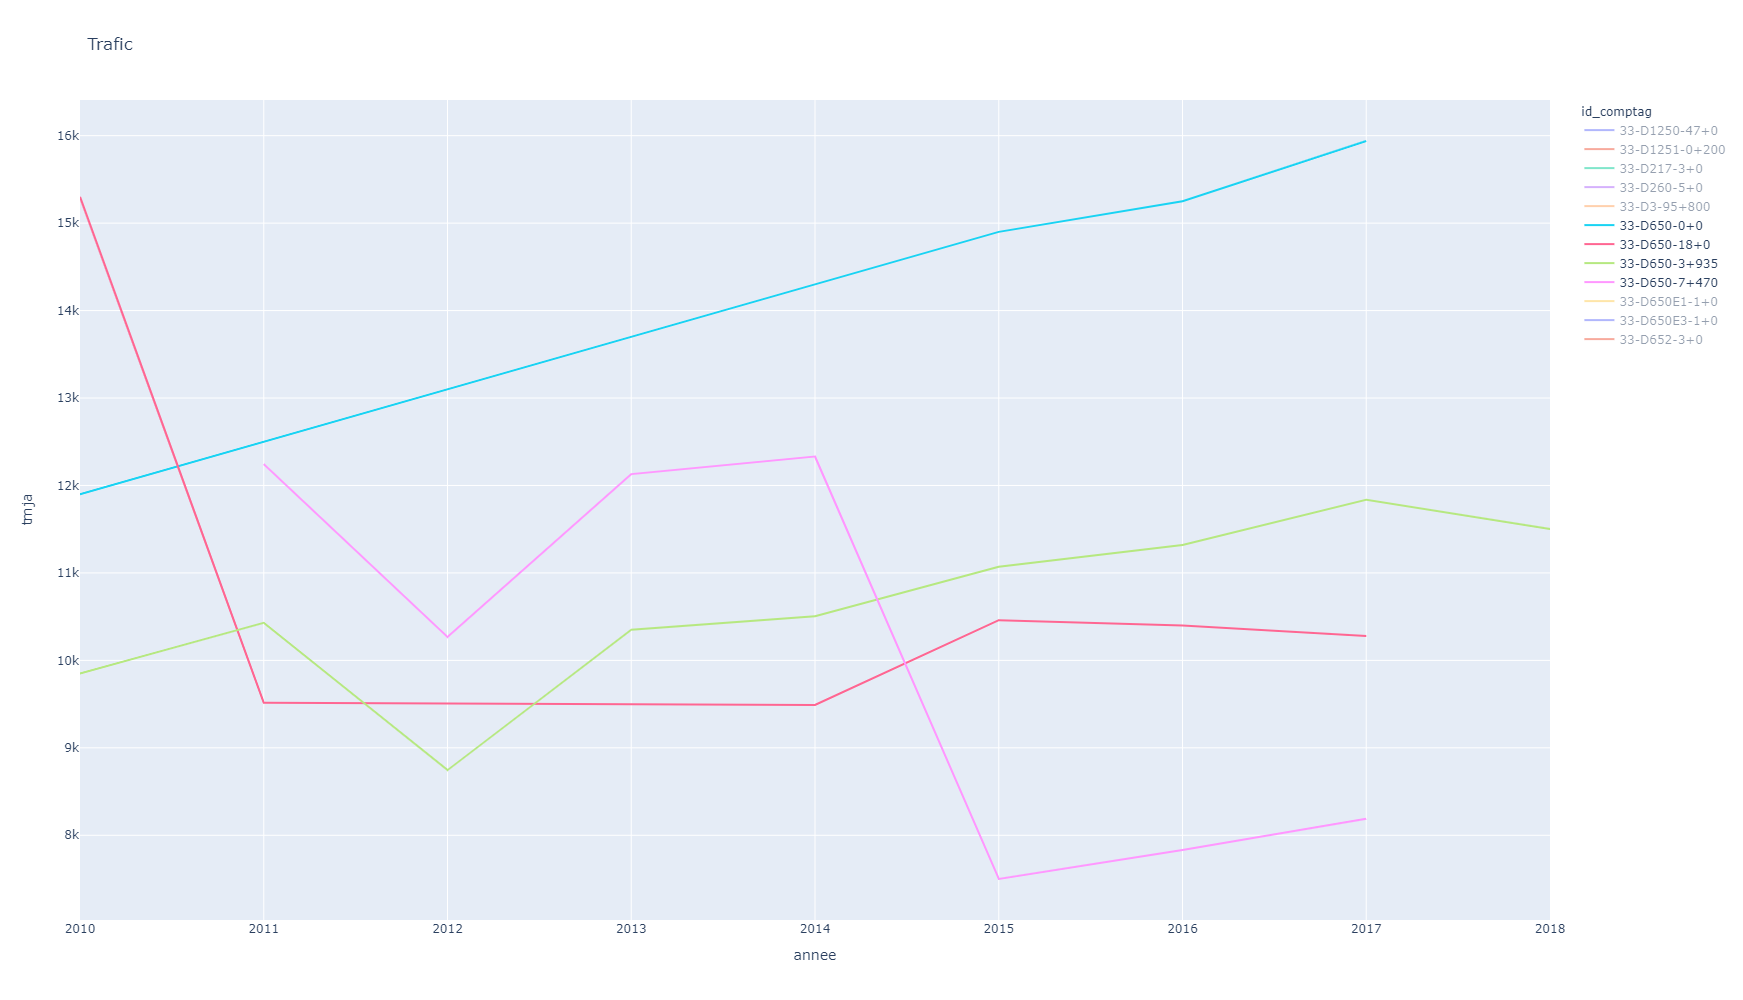

In [18]:
px.line(df_zone.loc[df_zone.zone==6].fillna(0), x='annee',y='tmja', color='id_comptag', title='Trafic',width=1500, height=1000)

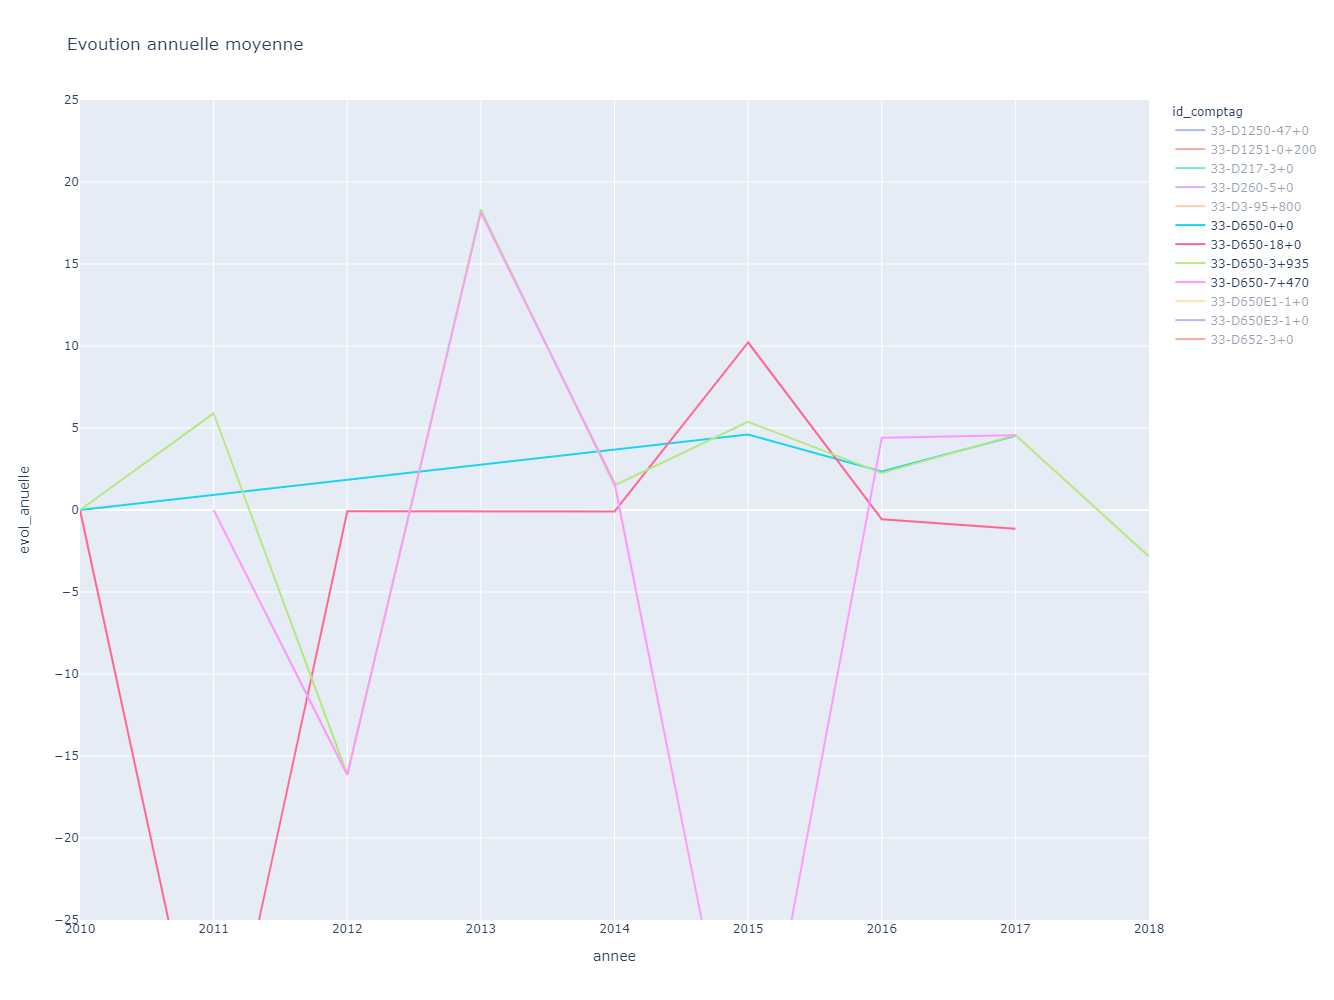

In [19]:
fig=px.line(df_zone.loc[df_zone.zone==6].fillna(0), x='annee',y='evol_anuelle', color='id_comptag', title='Evoution annuelle moyenne',width=1500, height=1000)
fig.update_layout(yaxis=dict(range=[-25,25],dtick = 5))

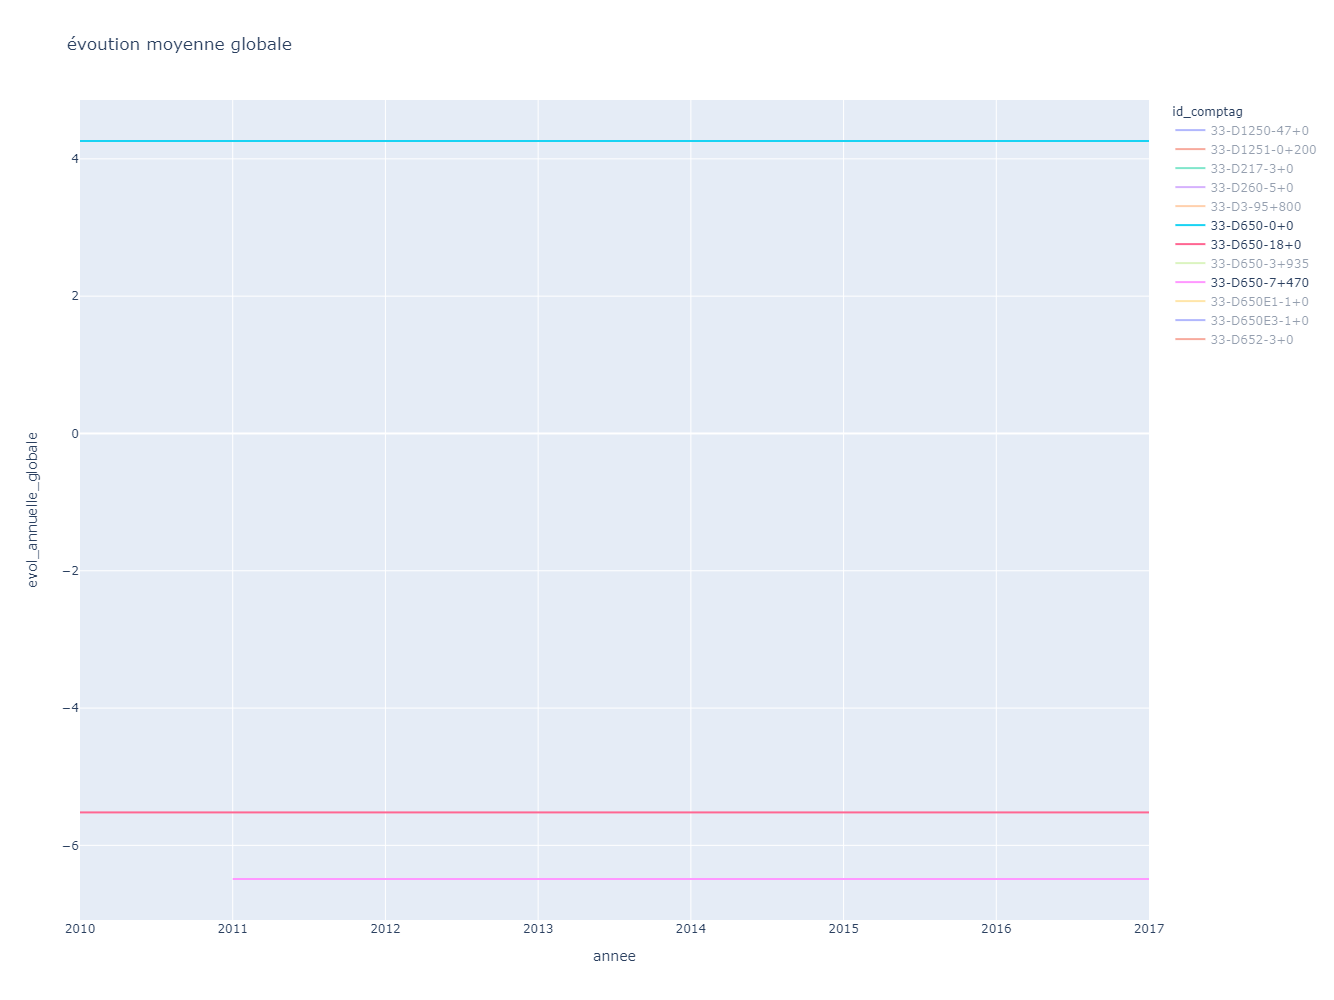

In [20]:
fig=px.line(df_zone.loc[df_zone.zone==6], x='annee',y='evol_annuelle_globale', color='id_comptag', title='évoution moyenne globale',width=1500, height=1000)
fig.update_layout(yaxis=dict(range=[-10,10],dtick = 2))

In [72]:
#stats sur un point de comptage
dfCpt=df.loc[df.id_comptag=='33-D1010-20+300'][['id_comptag','tmja','evol_anuelle']]
df[['id_comptag','tmja','evol_anuelle']].groupby('id_comptag').agg([lambda x : np.std(x)/np.mean(x)*100, np.std, np.mean, np.max, np.min, np.median, 
                                                                   lambda x : len(x)]).rename(columns={'<lambda_0>': 'coeff_variation',
                                        'std': 'ecart_type','mean': 'moyenne','amax':'max', 'amin':'min', 'median':'mediane','<lambda_1>':'nb_annee'})#.to_csv(
    #r'D:\Boulot\AffairesEnCours\SNCF_Reseau_PN\MaJ\C20SA00018_trafics_PN_RER_BM\Doc_travail\Donnees_produites\Donnees\analyse evolution OTV\stats_pt_references.csv')

tmja               \
                                             coeff_variation   ecart_type   
id_comptag                                                                  
33-D1010-20+300                                    10.651775   527.928025   
33-D11-30+0                                        20.139742   782.003928   
33-D1113-35+713                                    26.451335  1986.847791   
33-D1113-45+750                                     2.817075   273.995894   
33-D1113-53+0                                       1.412525   222.411941   
33-D1113-57+113                                     7.693974   545.382418   
33-D1251-0+200                                     21.831394  3334.294666   
33-D18-26+700                                      32.293490  1620.907709   
33-D2-70+0                                          4.133690   353.109453   
33-D210-2+0                                         0.000000          NaN   
33-D250-13+0                                        5.207370    63.445515   
33-D650-0+0                                        10.660034  1784.487858   
33-D650-18+0                                       17.920111  2072.550269   
33-D650-3+935                                       8.403601   946.896510   
33-D650-7+470                                      20.308407  2208.944878   
33-D650E1-1+0                                      11.875989  1088.157464   
33-D669-23+660                                      7.203839   455.554455   
BdxMet-avenue du 11 novembre--0.6223;44.9276        2.857560   553.664610   
BdxMet-rue de belair--0.6314;44.9415                0.000000          NaN   
BdxMet-rue de landegrand--0.6073;44.9516            2.269076   159.806133   
BdxMet-rue jean duvert--0.6226;44.919               0.000000          NaN   
BdxMet-rue louis fleuranceau--0.6105;44.8856        0.000000          NaN   

                                                                          \
                                                   moyenne    max    min   
id_comptag                                                                 
33-D1010-20+300                                4433.000000   4899   3826   
33-D11-30+0                                    3594.857143   4235   2000   
33-D1113-35+713                                6954.142857   7800   2450   
33-D1113-45+750                                9170.000000   9600   8814   
33-D1113-53+0                                 14728.750000  15251  14559   
33-D1113-57+113                                6630.625000   7976   6395   
33-D1251-0+200                                13226.750000  16128  10279   
33-D18-26+700                                  4489.400000   6327   3000   
33-D2-70+0                                     7908.571429   8610   7580   
33-D210-2+0                                    1170.000000   1170   1170   
33-D250-13+0                                   1128.000000   1180   1032   
33-D650-0+0                                   14497.250000  15939  11900   
33-D650-18+0                                  10707.571429  15300   9490   
33-D650-3+935                                 10623.333333  11837   8747   
33-D650-7+470                                 10070.142857  12330   7500   
33-D650E1-1+0                                  8364.333333   9585   6621   
33-D669-23+660                                 5962.111111   6700   5375   
BdxMet-avenue du 11 novembre--0.6223;44.9276  13700.500000  14092  13309   
BdxMet-rue de belair--0.6314;44.9415           3203.000000   3203   3203   
BdxMet-rue de landegrand--0.6073;44.9516       4980.000000   5093   4867   
BdxMet-rue jean duvert--0.6226;44.919          8573.000000   8573   8573   
BdxMet-rue louis fleuranceau--0.6105;44.8856   7040.000000   7040   7040   

                                                                \
                                              mediane nb_annee   
id_comptag                                                       
33-D1010-20+300                

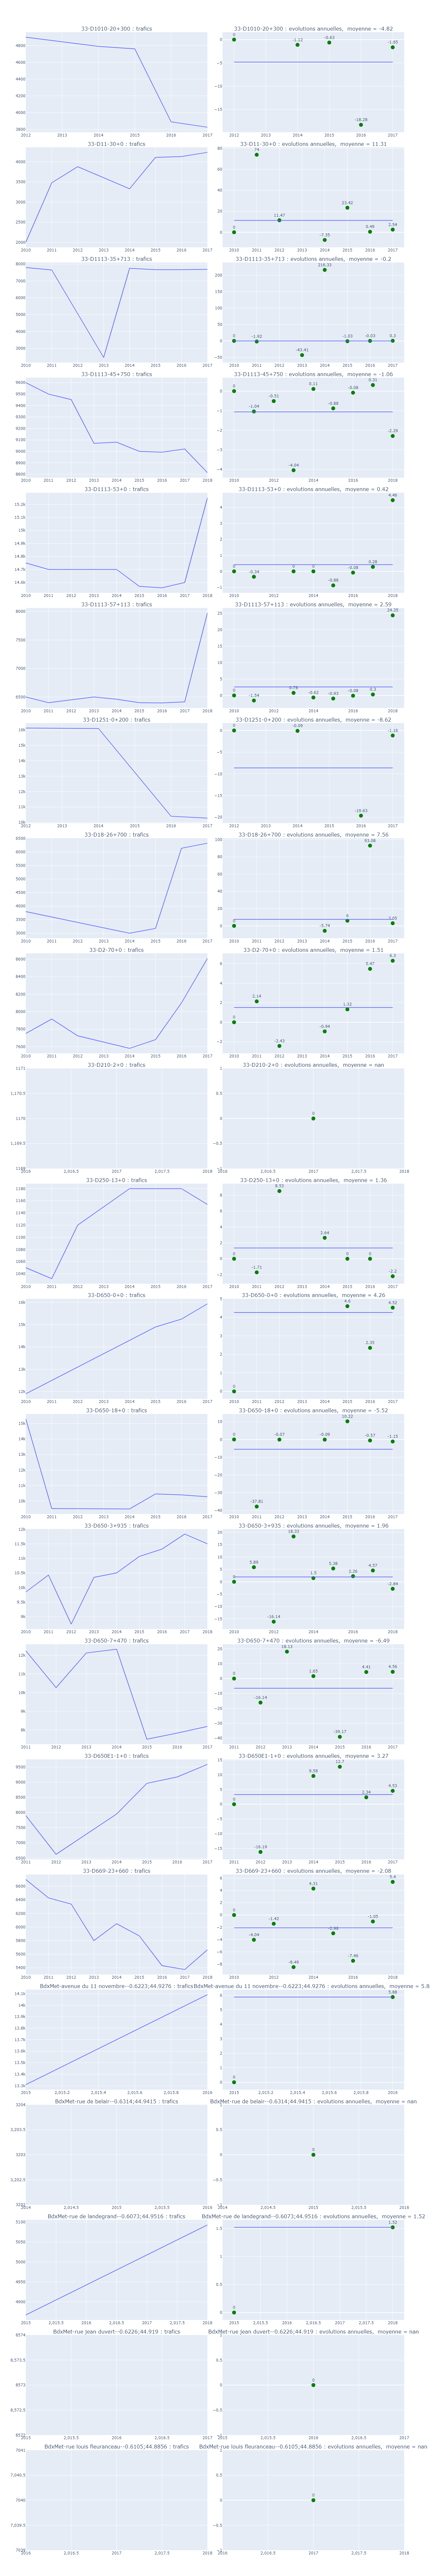

In [62]:
#graphs complets
listIdComptag=df.id_comptag.unique()
nbPoints=len(listIdComptag)
titres=[e for a in [(f'{c} : trafics', f'{c} : evolutions annuelles,  moyenne = {df.loc[df.id_comptag==c].evol_annuelle_globale.unique()[0]}') for c in listIdComptag] for e in a]
fig = make_subplots(rows=nbPoints, cols=2, subplot_titles=titres,
                    horizontal_spacing=0.04,vertical_spacing=0.006)
for i,c in enumerate(listIdComptag) : 
    dfIdUnique=df.loc[df['id_comptag']==c]
    fig.add_trace(px.line(dfIdUnique, x='annee',y='tmja')['data'][0], row=i+1,col=1)
    fig.add_trace(px.scatter(dfIdUnique.fillna(0), x='annee',y='evol_anuelle', text='evol_anuelle')['data'][0], row=i+1,col=2)
    fig.data[-1].update(marker=dict(size=12, color='green'),textposition='top center')
    fig.add_trace(px.line(dfIdUnique, x='annee',y='evol_annuelle_globale')['data'][0], row=i+1,col=2)
    #fig.data[-1].update(textposition='top center')
fig.update_layout(height=8000, width=1500)

# **Visu Folium des points de comptage**
> on va tester le graph dans Folium

In [105]:
#recuperer les donnees OTV sans les données de trafic
#passer les comptages en lignes
rqt_graphs="""SELECT id_comptag,type_poste,unnest(array[2019, 2018, 2017,2016,2015,2014,2013,2012,2011,2010]) AS annee,
       unnest(array[tmja_2019, tmja_2018, tmja_2017,tmja_2016,tmja_2015, tmja_2014,tmja_2013,tmja_2012,tmja_2011,tmja_2010]) AS tmja,
       unnest(array[pc_pl_2019, pc_pl_2018, pc_pl_2017,pc_pl_2016,pc_pl_2015, pc_pl_2014,pc_pl_2013,pc_pl_2012,pc_pl_2011,pc_pl_2010]) AS pc_pl
 FROM comptage.na_2010_2019_p"""
with ct.ConnexionBdd('gti_otv_pg11', localisation='boulot') as c : 
    dfZone=gp.read_postgis("select geom, id_comptag, type_poste from comptage.na_2010_2019_p where geom is not null",c.sqlAlchemyConn)
    dfGraphs=pd.read_sql(rqt_graphs,c.sqlAlchemyConn)
#ajouter les conversion en wgs84
dfZone['wgs84']=dfZone.geometry.to_crs('epsg:4326')
dfZone['coords_wgs84']=dfZone.wgs84.apply(lambda x : [round(x.y,5),round(x.x,5)])

In [141]:
#creer la carte et les cluster
map_1 = folium.Map(location=[45.829, 1.253])

markerClusterPerm = MarkerCluster(name='Permanent',overlay=True)
markerClusterTourn =MarkerCluster(name='Tournant',overlay=True)
markerClusterPonct =MarkerCluster(name='Ponctuel',overlay=True)

In [145]:
html="""<html>
<head>
  <style>
    .error {
        color: red;
    }
  </style>
  <script type="text/javascript" src="https://cdn.jsdelivr.net/npm//vega@5"></script>
  <script type="text/javascript" src="https://cdn.jsdelivr.net/npm//vega-lite@4.8.1"></script>
  <script type="text/javascript" src="https://cdn.jsdelivr.net/npm//vega-embed@6"></script>
  
  <script type="text/javascript">
function Hide (addr) { document.getElementById(addr).style.visibility = "hidden";	}
function Show (addr) { document.getElementById(addr).style.visibility = "visible";	}

function toggle(anId)
{
	if (document.getElementById(anId).style.visibility == "hidden")	{	Show(anId);	}
	else															{	Hide(anId);	}
}

window.onload = function () { Hide("vis_h");Hide("vis_a")	};

</script>

  
</head>
<body>

  <a href="#" onclick = "toggle('vis_h');">afficher graph horaire</a>
  <a href="#" onclick = "toggle('vis_a');">afficher graph annuel</a>

  <div id="vis_h"</div>
  <script>
    (function(vegaEmbed) {
      var spec = {"config": {"view": {"continuousWidth": 400, "continuousHeight": 300}}, "data": {"name": "data-7e79fe51a9ff47bbee2be7923cb527f5"}, "mark": "line", "encoding": {"color": {"type": "nominal", "field": "type_jour"}, "x": {"type": "temporal", "field": "heure"}, "y": {"type": "quantitative", "field": "nb_veh"}}, "title": "33-A630-10+547", "$schema": "https://vega.github.io/schema/vega-lite/v4.8.1.json", "datasets": {"data-7e79fe51a9ff47bbee2be7923cb527f5": [{"id_comptag": "33-A630-10+547", "heure": "2019-01-01T00:00:00", "nb_veh": 542, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T01:00:00", "nb_veh": 354, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T02:00:00", "nb_veh": 251, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T03:00:00", "nb_veh": 239, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T04:00:00", "nb_veh": 410, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T05:00:00", "nb_veh": 896, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T06:00:00", "nb_veh": 2358, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T07:00:00", "nb_veh": 3041, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T08:00:00", "nb_veh": 2496, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T09:00:00", "nb_veh": 3104, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T10:00:00", "nb_veh": 3659, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T11:00:00", "nb_veh": 3913, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T12:00:00", "nb_veh": 3847, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T13:00:00", "nb_veh": 3785, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T14:00:00", "nb_veh": 4032, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T15:00:00", "nb_veh": 4050, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T16:00:00", "nb_veh": 3948, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T17:00:00", "nb_veh": 3655, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T18:00:00", "nb_veh": 3747, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T19:00:00", "nb_veh": 3478, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T20:00:00", "nb_veh": 2309, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T21:00:00", "nb_veh": 1361, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T22:00:00", "nb_veh": 1076, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T23:00:00", "nb_veh": 830, "type_jour": "tmja"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T00:00:00", "nb_veh": 360, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T01:00:00", "nb_veh": 199, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T02:00:00", "nb_veh": 157, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T03:00:00", "nb_veh": 206, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T04:00:00", "nb_veh": 437, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T05:00:00", "nb_veh": 1101, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T06:00:00", "nb_veh": 3155, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T07:00:00", "nb_veh": 3906, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T08:00:00", "nb_veh": 2792, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T09:00:00", "nb_veh": 3401, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T10:00:00", "nb_veh": 3895, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T11:00:00", "nb_veh": 4020, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T12:00:00", "nb_veh": 4013, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T13:00:00", "nb_veh": 4085, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T14:00:00", "nb_veh": 4266, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T15:00:00", "nb_veh": 4228, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T16:00:00", "nb_veh": 3983, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T17:00:00", "nb_veh": 3398, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T18:00:00", "nb_veh": 3564, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T19:00:00", "nb_veh": 3471, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T20:00:00", "nb_veh": 2374, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T21:00:00", "nb_veh": 1374, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T22:00:00", "nb_veh": 1097, "type_jour": "tmjo"}, {"id_comptag": "33-A630-10+547", "heure": "2019-01-01T23:00:00", "nb_veh": 796, "type_jour": "tmjo"}]}};
      var embedOpt = {"mode": "vega-lite"};

      function showError(el, error){
          el.innerHTML = ('<div class="error" style="color:red;">'
                          + '<p>JavaScript Error: ' + error.message + '</p>'
                          + "<p>This usually means there's a typo in your chart specification. "
                          + "See the javascript console for the full traceback.</p>"
                          + '</div>');
          throw error;
      }
      const el = document.getElementById('vis_h');
      vegaEmbed("#vis_h", spec, embedOpt)
        .catch(error => showError(el, error));
    })(vegaEmbed) ;

  </script>
  
  <div id="vis_a"></div>
  <script>
    (function(vegaEmbed) {
      var spec = {"config": {"view": {"continuousWidth": 400, "continuousHeight": 300}}, "data": {"name": "data-c0b141cf83b3e41b7414a228db6c1303"}, "mark": "bar", "encoding": {"x": {"type": "quantitative", "field": "annee"}, "y": {"type": "quantitative", "field": "tmja"}}, "$schema": "https://vega.github.io/schema/vega-lite/v4.8.1.json", "datasets": {"data-c0b141cf83b3e41b7414a228db6c1303": [{"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2019, "tmja": 67461.0, "pc_pl": 7.76}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2018, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2017, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2016, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2015, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2014, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2013, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2012, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2011, "tmja": null, "pc_pl": null}, {"id_comptag": "33-A630-10+547", "type_poste": "permanent", "annee": 2010, "tmja": null, "pc_pl": null}]}};
      var embedOpt = {"mode": "vega-lite"};

      function showError(el, error){
          el.innerHTML = ('<div class="error" style="color:red;">'
                          + '<p>JavaScript Error: ' + error.message + '</p>'
                          + "<p>This usually means there's a typo in your chart specification. "
                          + "See the javascript console for the full traceback.</p>"
                          + '</div>');
          throw error;
      }
      const el = document.getElementById('vis_a');
      vegaEmbed("#vis_a", spec, embedOpt)
        .catch(error => showError(el, error));
    })(vegaEmbed);

  </script>
  
</body>
</html>
    """

In [146]:
for cpt in dfZone[['id_comptag','type_poste','coords_wgs84']].to_dict('records'):
    if cpt["id_comptag"]=="33-A630-10+547" : 
        graph=alt.Chart(dfGraphs.loc[dfGraphs.id_comptag==cpt["id_comptag"]], title=cpt["id_comptag"]).mark_bar().encode(x='annee',y='tmja')#.save(r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\OTV\test_visu\33-A630-10+547\annuel.html')
        iframe = branca.element.IFrame(html=html, width=500, height=300)
        popup,icon=folium.Popup(iframe), folium.Icon(color='green')#
        folium.Marker(cpt["coords_wgs84"], popup=popup, icon=icon).add_to(markerClusterPerm)
        break
    else :
        continue
    if(cpt["type_poste"]=="permanent"):
        graph=alt.Chart(dfGraphs.loc[dfGraphs.id_comptag==cpt["id_comptag"]], title=cpt["id_comptag"]).mark_bar().encode(x='annee',y='tmja').to_json()
        popup,icon=folium.Popup(), folium.Icon(color='green')
        folium.VegaLite(graph).add_to(popup)
        folium.Marker(cpt["coords_wgs84"], popup=popup, icon=icon).add_to(markerClusterPerm)
    elif cpt["type_poste"]=="tournant":
        graph=alt.Chart(dfGraphs.loc[dfGraphs.id_comptag==cpt["id_comptag"]], title=cpt["id_comptag"]).mark_bar().encode(x='annee',y='tmja').to_json()
        popup,icon=folium.Popup(), folium.Icon(color='orange')
        folium.VegaLite(graph).add_to(popup)
        folium.Marker(cpt["coords_wgs84"], popup=popup, icon=icon).add_to(markerClusterTourn)
    elif cpt["type_poste"]=="ponctuel":
        popup,icon=folium.Popup(cpt['annee']), folium.Icon(color='red')
        folium.VegaLite(graph).add_to(popup)
        folium.Marker(cpt["coords_wgs84"], popup=popup, icon=icon).add_to(markerClusterPonct)
markerClusterPerm.add_to(map_1)
markerClusterTourn.add_to(map_1)
markerClusterPonct.add_to(map_1)
folium.LayerControl().add_to(map_1)

In [147]:
map_1

In [11]:
alt.Chart(dfGraphs.loc[dfGraphs.id_comptag==cpt["id_comptag"]], title=cpt["id_comptag"]).mark_bar().encode(x='annee',y='tmja')

alt.Chart(...)

In [274]:
dfZone.loc[dfZone.type_poste=='permanent'][['id_comptag','type_poste','coords_wgs84']].head(1)

,id_comptag,type_poste,coords_wgs84
26,LimMet-place winston churchill-1.2523;45.8323,permanent,"[45.83234, 1.25233]"


In [110]:
alt.Chart(dfGraphs.loc[dfGraphs.id_comptag==cpt["id_comptag"]]).mark_bar().encode(x='annee',y='tmja'
        ).save(r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\OTV\test_visu\33-A630-10+547\annuel.html')